# LSTM Lyrics Generation Model

At first, we import the relevant libraries. The data for lyrics generation comes from kaggle linked <a href ='https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres'> here.</a> This dataset has songs from many language, but here we will focus only on english language lyrics first. So we refine this dataset so as to only get the english language songs. Initially there are about 3 lakh 80 thousand songs in this dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os 
import tensorflow as tf

# keras module for building LSTM 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# csv file
#importing the data downloaded from the link above
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/college 6 sem shit/lyrics-data.csv")

Mounted at /content/drive


In [3]:
# first few rows
df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


We now delete the Alink, SName, SLink columns as tgey are irrelevant to present application.

In [4]:
# drop
df.drop(['ALink','SName','SLink'],axis=1,inplace=True)

In [5]:
# shape
df.shape

(379931, 2)

In [6]:
# value count of language types
df['language'].value_counts()

en     191814
pt     157393
es       9917
rw       1679
it       1432
fr       1225
de        844
fi        145
sv        112
ro         97
no         89
is         86
tl         69
pl         47
gl         36
ga         32
tr         32
id         26
cy         23
su         19
af         19
sw         19
ko         17
nl         14
da         13
ca         13
et         13
ms          8
ja          7
st          7
ht          5
gd          4
ru          4
ar          4
eu          4
cs          3
ku          3
ny          3
mg          3
lg          2
jw          2
hu          2
vi          1
iw          1
sr          1
hmn         1
hr          1
fa          1
sq          1
zh          1
lv          1
sl          1
Name: language, dtype: int64

In [7]:
initial_len = len(df) #obtaining the initial number of lyrics from all languages
#dropping all non english songs
df = df[df['language']=='en']
print('The percentage of lyrics retained is {}'. format((len(df)/initial_len)*100))

The percentage of lyrics retained is 50.48653571306369


Doing further housekeeping stuff.

In [8]:
#we now reset the index and drop the language column also
df.reset_index(inplace=True)
df.drop(['language'],axis=1,inplace=True)
df.drop(['index'],axis=1,inplace=True)
df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))
df.head()

,Lyric,Number_of_words
0,I feel so unsure\nAs I take your hand and lead...,299
1,"Don't let them fool, ya\nOr even try to school...",161
2,"Baby, let's cruise, away from here\nDon't be c...",159
3,"Know it sounds funny\nBut, I just can't stand ...",175
4,You've got that look again\nThe one I hoped I ...,215


In [9]:
# statistical info
df['Number_of_words'].describe()

count    191814.000000
mean        250.229159
std         159.288438
min           1.000000
25%         147.000000
50%         211.000000
75%         304.000000
max        3422.000000
Name: Number_of_words, dtype: float64

The average song length here is 250, so for ease of training, we only use a subset of the data at first with 100 or less words

In [10]:
df = df[:700]

In [11]:
df.shape

(700, 2)

<ipython-input-12-8b69dec7c5b1>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

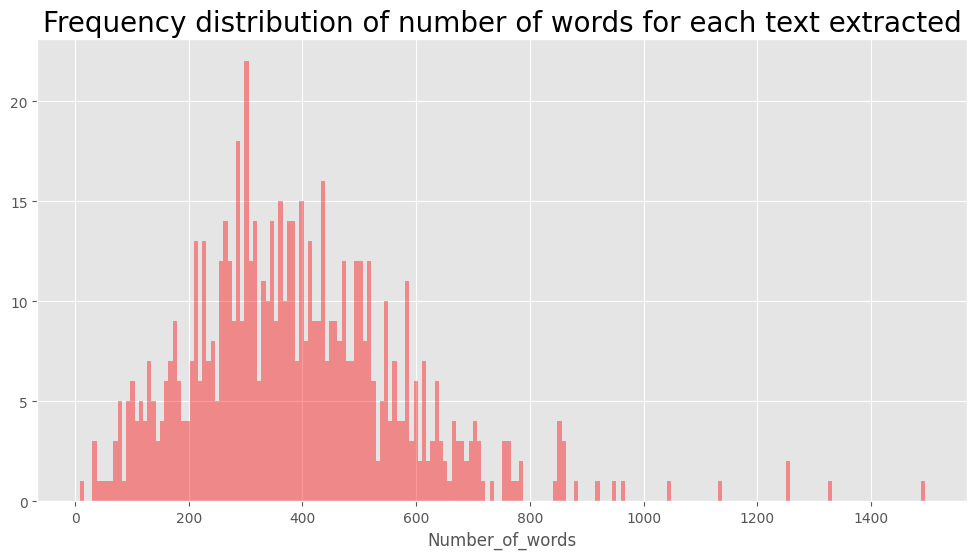

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

In [ ]:
qw# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(df['Lyric'].astype(str))
tokenized_sentences[0]

In [ ]:
# Slash sequences into n gram sequence
count = 0
input_sequences = list()
for i in tokenized_sentences:
    count = count+1
    print(count)
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [15]:
input_sequences[:10]

array([[   0,    0,    0, ...,    0,    2,   68],
       [   0,    0,    0, ...,    2,   68,   22],
       [   0,    0,    0, ...,   68,   22, 5450],
       ...,
       [   0,    0,    0, ...,   60,   13,  281],
       [   0,    0,    0, ...,   13,  281,    7],
       [   0,    0,    0, ...,  281,    7,  563]], dtype=int32)

Setting the N-grams sequence as predictors and the next word of the N-gram as label. 

In [16]:
# create predictors and label
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

We now create and train the LSTM model

In [17]:
# create model
model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(X, y, epochs=10, verbose=1, callbacks=[earlystop])

Epoch 1/10
8563/8563 [==============================] - 1121s 130ms/step - loss: 5.4911 - accuracy: 0.1174
Epoch 2/10
8563/8563 [==============================] - 974s 114ms/step - loss: 4.4497 - accuracy: 0.2289
Epoch 3/10
8563/8563 [==============================] - 968s 113ms/step - loss: 3.8684 - accuracy: 0.3037
Epoch 4/10
8563/8563 [==============================] - 966s 113ms/step - loss: 3.4829 - accuracy: 0.3552
Epoch 5/10
8563/8563 [==============================] - 963s 112ms/step - loss: 3.2060 - accuracy: 0.3937
Epoch 6/10
8563/8563 [==============================] - 962s 112ms/step - loss: 3.0042 - accuracy: 0.4217
Epoch 7/10
8563/8563 [==============================] - 962s 112ms/step - loss: 2.8456 - accuracy: 0.4446
Epoch 8/10
8563/8563 [==============================] - 963s 112ms/step - loss: 2.7209 - accuracy: 0.4617
Epoch 9/10
8563/8563 [==============================] - 961s 112ms/step - loss: 2.6233 - accuracy: 0.4742
Epoch 10/10
8563/8563 [======================

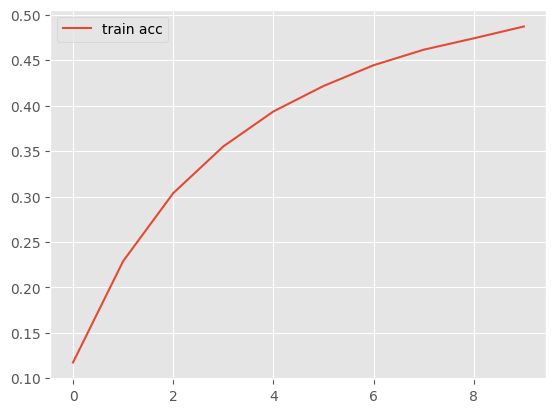

<Figure size 640x480 with 0 Axes>

In [20]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Generate new song lyrics

Now our model is ready.So lets write the function to predict the next word based on the input words (or seed text). We will first tokenize the seed text, pad the sequences and pass into the trained model to get predicted word. The multiple predicted words can be appended together to get predicted sequence.

In [30]:
def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predict_x=model.predict(token_list, verbose=0) 
        predicted=np.argmax(predict_x,axis=1)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

Our function is ready so are you ready to generate your own lyrics

In [31]:
complete_this_song("the sky is blue", 40)

'the sky is blue and the world of the world like the world is the one that we spent and i know that i love you and i love you baby i love you but i love you but i love you so i'

In [32]:
complete_this_song("This is the beginning", 140)

"This is the beginning of the world is the world we are the world is the girl we going in the air then we get the streets we gonna go in the air yeah she's gonna party the sound don't be alarmed but my heart was calling up in the dark like hoo oo oo oo oo oo oo oo oo oo ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah"

In [33]:
complete_this_song("everything sucks", 80)

"everything sucks to go and i don't know what i don't wanna do it anymore you don't have to worry i don't wanna be a murderer that's why i don't know where you don't know it's just a little closer to say what you heard i know you don't know how to feel a dream but i don't wanna know i don't wanna wake up from you i wanna take you and i hope i wanna let you go i don't know"

# Save the model

In [19]:
# save model
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/college 6 sem shit/rhapsody_comp1_50word_acc.h5')

In [34]:
from keras.models import load_model
model2 = load_model('/content/drive/MyDrive/college 6 sem shit/rhapsody_comp1_50word_acc.h5')